In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Loading Dependency
import re
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import Counter
from rdkit import Chem
from rdkit.Chem import AllChem
import warnings
warnings.filterwarnings("ignore")

from utils.draw_utils import draw_mols, draw_rxn, clear_mapnum_rxn
from utils.tpl_utils.test_mask_tpl import smi_tokenizer
from utils.data_utils import extract_mapping, reconstruct_mapping, get_fragment_smarts, clear_map_number
from utils.tpl_utils.generate_retro_templates import clear_mapnum

from rdchiral.template_extractor import extract_from_reaction, get_fragments_for_changed_atoms
from rdchiral.main import rdchiralRunText
from data_processing.build_reaction_centers import find_center

# Main inference function (including loading models)
from inference import run_inference as customize_tpl
from inference import retrieve_embeddings, whether_in_scoped, basic_validity_check

BASE='/apdcephfs/private_yuewan/template_synthesis_dataset'

Loading from ./checkpoint_wnoise/generalize/model_52000_wz.pt


## Prepare Sample Data:

In [3]:
# Load Data
data = pd.read_csv(BASE+'/data/template/main_story_test.csv')
data_train = pd.concat([
    pd.read_csv(BASE+'/data/template/main_story_train.csv'),
    pd.read_csv(BASE+'/data/template/main_story_val.csv')])
data_train.reset_index(inplace=True, drop=True)

with open(BASE+'/intermediate/prod_centers.pk', 'rb') as f:
    prod_centers = pickle.load(f)
with open(BASE+'/intermediate/rt2prod_centers.pk', 'rb') as f:
    rt2prod_centers = pickle.load(f)

In [4]:
# Choose Sample data
instance = data.iloc[0]
raw_rxn, gt_templates, rt_token = instance['raw_rxn'], instance['templates'], instance['rxn_class']
gt_templates = gt_templates.replace(' ','')
prod_smiles = clear_mapnum_rxn(raw_rxn).split('>>')[1]

Selected Reaction:
CC(C)(C)OC(=O)OC(=O)OC([CH3])([CH3])[CH3].[CH3]C(=O)c1[cH][cH]c2[nH][cH][cH]c2[cH]1>>[CH3]C(=O)c1[cH][cH]c2c([cH][cH]n2C(=O)OC([CH3])([CH3])[CH3])[cH]1


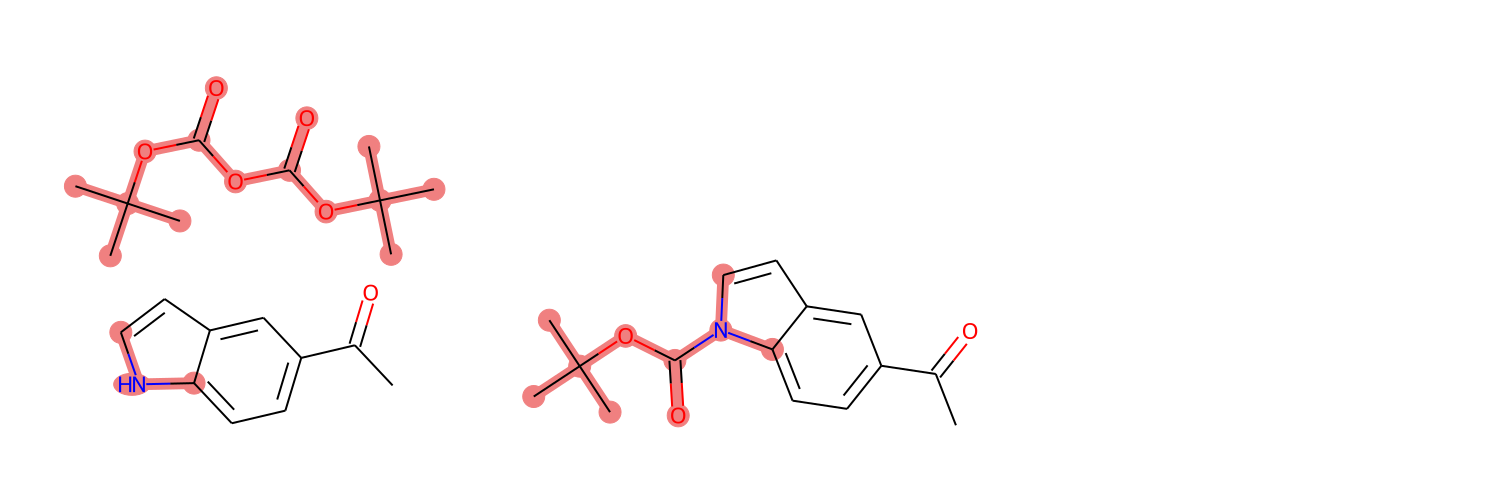

Corresponding Template:
[CH3]-[C](-[CH3])(-[CH3])-[O]-[C](=[O])-[n](:[c]):[cH]>>C-C(-C)(-C)-O-C(=O)-O-[C](=[#8])-[#8]-[C](-[C])(-[C])-[C].[c]:[nH]:[c]


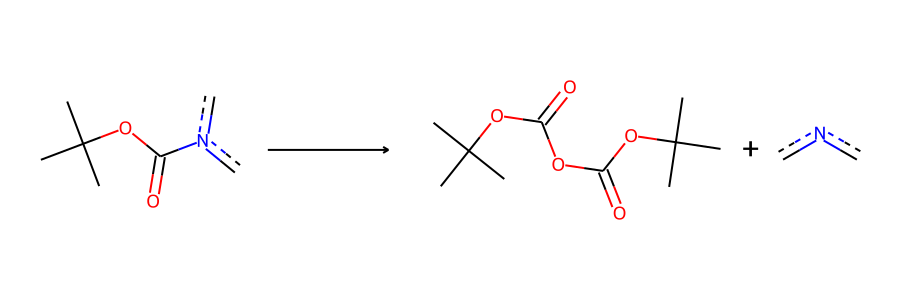

In [5]:
# Plot the reaction and template
print('Selected Reaction:')
print(clear_mapnum_rxn(raw_rxn))
draw_mols(clear_mapnum_rxn(raw_rxn).split('>>'), gt_templates.split('>>')[::-1])
print('Corresponding Template:')
print(gt_templates)
draw_rxn(gt_templates)

## Begin Inference:

In [6]:
# Use ground truth reaction center
proposed_rc = gt_templates.split('>>')[0]
proposed_rc

'[CH3]-[C](-[CH3])(-[CH3])-[O]-[C](=[O])-[n](:[c]):[cH]'

In [7]:
# Randomly select a reaction center
_, potential_reaction_centers = find_center((raw_rxn, None), prod_centers, inference=True)
proposed_rc = np.random.choice(potential_reaction_centers, replace=False)
proposed_rc

'[CH3]-[C]=[O]'

#### Generate template based on `proposed_rc` and `rt_token`:

- If `regularize` = False, the generation will be guided by `potential_rc`. If `potential_rc` is None, then the algorithm will randomly select one by `find_center` function internally. If `add_noise` = True, the algorithm will first identify the original reaction center from atom-mapped reaction and then mark it as $<$NOISE$>$.

- If `regularize` = True, the setting is the same as training. `potential_rc` will be treated as $<$NOISE$>$ is `add_noise` = True and the generation will be guided by the original reaction center.

- If `add_noise` = False, the input reaction SMILES does not need to contain atom-mapping information.

- If `prod_frag_constraint` = True, the head reaction center from the generated outcome will be exactly the same as the `potential_rc` or the original reaction center (depending on `regularize`)


For template customization setting, the `raw_rxn` is simply the undesired reaction path with atom-mapping (can be tagged by [RXNMapper](https://github.com/rxn4chemistry/rxnmapper))

Start:

Proposed reaction center:
[CH3]-[C]=[O]

Final mask input:
[CH3:1]-[C:2](-[CH3:3])(-[CH3:4])-[O:5]-[C:6](=[O:7])-[n:15]1:[c:14]2:[cH:13]:[cH:12]:[c:11](-[C:9](-[CH3:8])=[O:10]):[cH:19]:[c:18]:2:[cH:17]:[cH:16]:1>>[CH3:1][C:2]([CH3:3])([CH3:4])[O:5][C:6](=[O:7])[n:15]1[c:14]2[cH:13][cH:12][c:11](<MASK>)[cH:19][c:18]2[cH:17][cH:16]1

Finished:

[CH3]-[C]=[O]>>[C]-[CH](-[OH])-[OH]


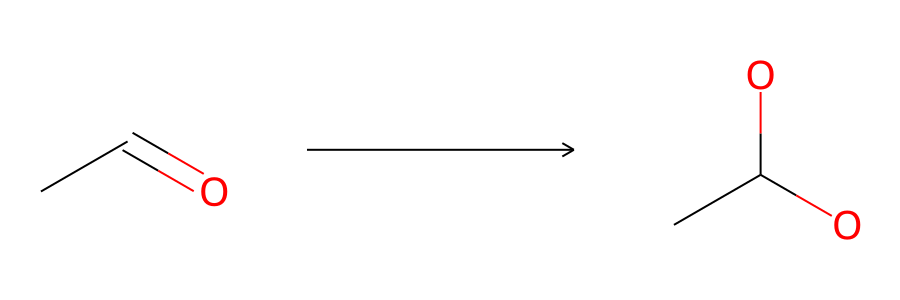

[CH3]-[C]=[O]>>C-C-O-[CH2]-[C]=[#8]


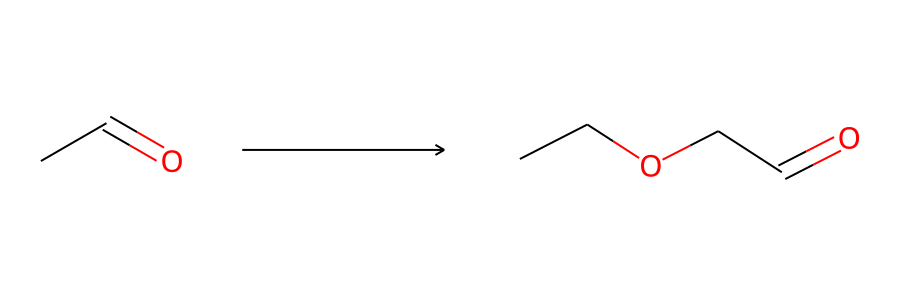

[CH3]-[C]=[O]>>C-O-[CH2]-[C]=[#8]


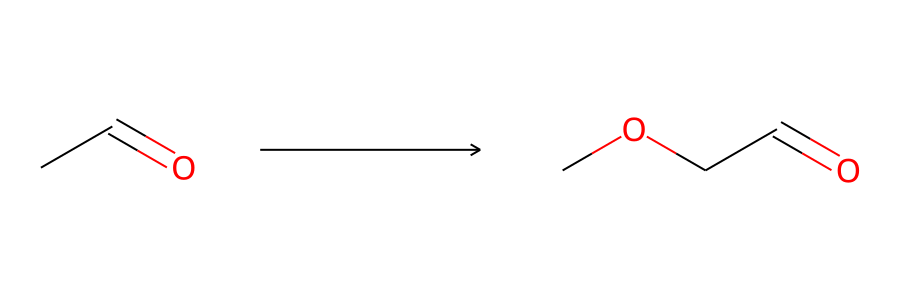

[CH3]-[C]=[O]>>C-C-C(=O)-[O]-[C]=[#8]


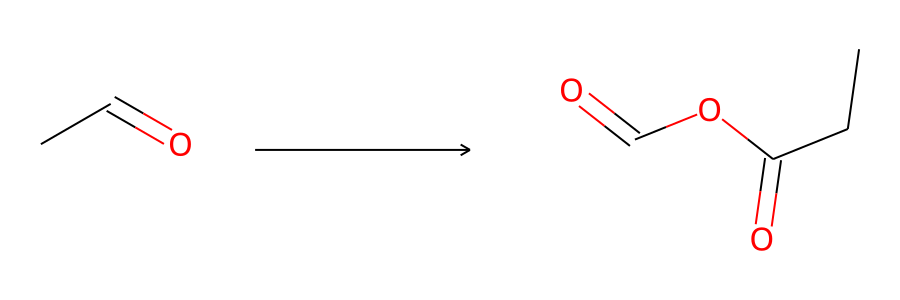

[CH3]-[C]=[O]>>C-O-[CH2]-[C].[#8]=[C]-[OH]


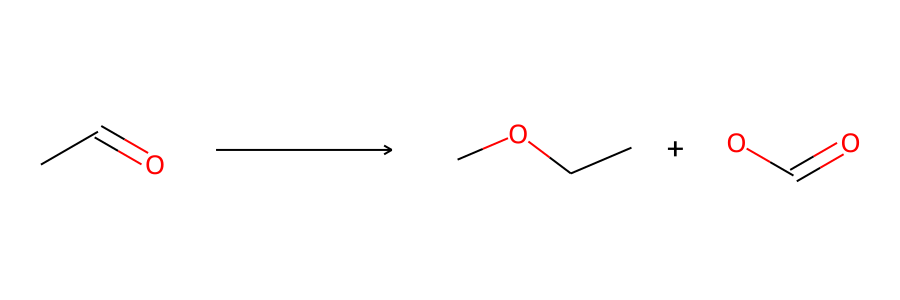

[CH3]-[C]=[O]>>[C]-[CH2]-[OH]


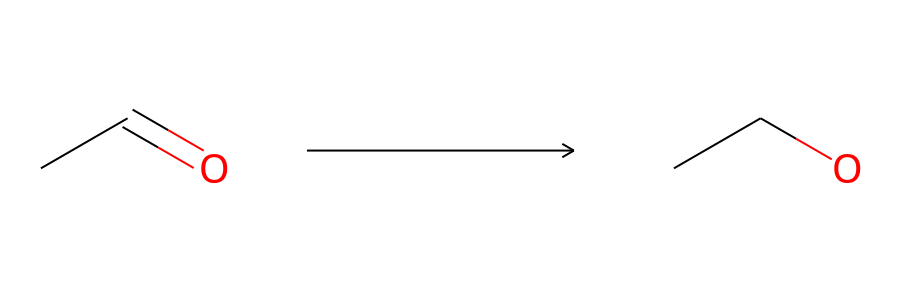

[CH3]-[C]=[O]>>C-O-[CH2]-[C].[#8]=[C]-[O-]


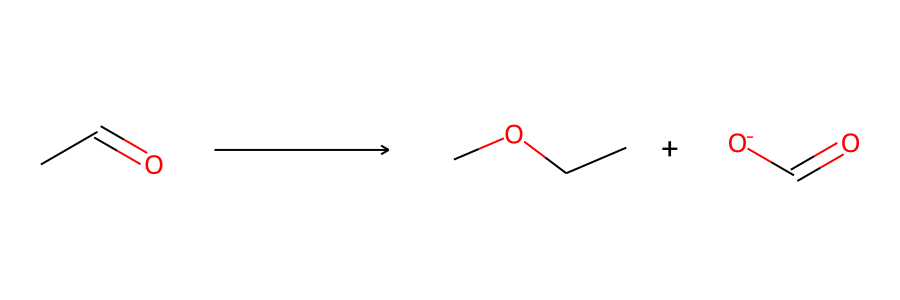

[CH3]-[C]=[O]>>[#8]=[C]-[CH2]-[OH]


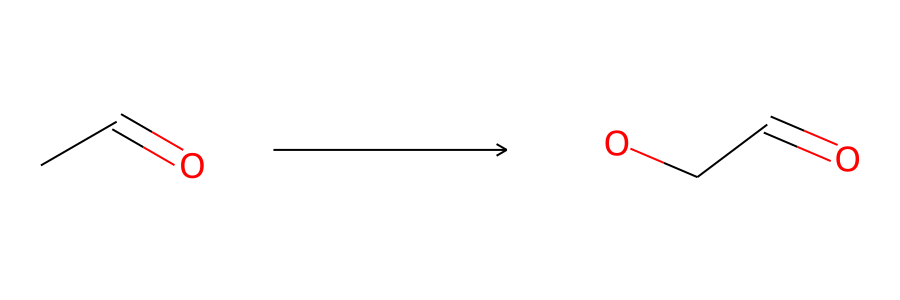

[CH3]-[C]=[O]>>C-C(-C)(-C)-O-C(=O)-[CH2]-[C]=[#8]


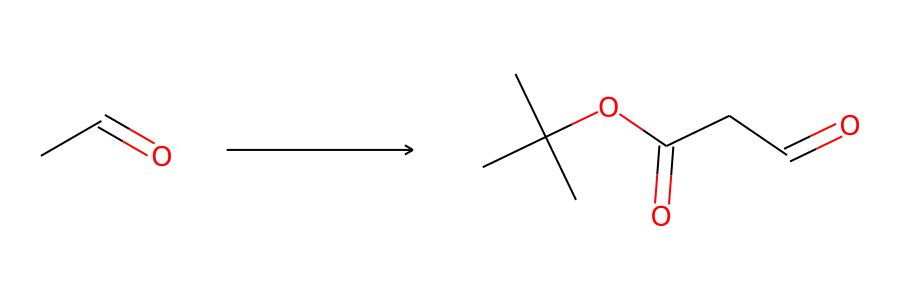


Total number: 9 10


In [8]:
print('Start:')
gen_tpls, gen_scores = customize_tpl(
                raw_rxn = raw_rxn, 
                potential_rc = proposed_rc,
                rt_token = rt_token,          
                prod_frag_constraint = True, 
                regularize = False,           
                beam_size = 10,               
                add_noise = False,
                verbose=True)

gen_tpls = np.array(gen_tpls)[np.argsort(gen_scores)[::-1]]
print('\nFinished:\n')
generated_templates = []
for gen_tpl in set(gen_tpls):
    if basic_validity_check(gen_tpl):
        generated_templates.append(gen_tpl)
        print(gen_tpl)
        draw_rxn(gen_tpl)
print('\nTotal number:', len(generated_templates), len(gen_tpls))

#### Build reaction from generated template:

<span style="color:red">[WARNING]</span> The template atom-mapping algorithm modified from [RXNMapper](https://github.com/rxn4chemistry/rxnmapper) has relatively poor performance compared to the full reaction atom-mapping. The failure of building the reaction may be caused by either the invalid template or the mistaken atom-mapping.

In [10]:
# Tag atom-mapping and run reaction
from generalize_postprocess import get_mapped_center_main, assign_am, reassign_am

probe_list = []
result_list = []

for tpl in generated_templates:
    mapped_tpl = get_mapped_center_main(tpl, postprocess=True)
    print(mapped_tpl)
    reacts = rdchiralRunText(mapped_tpl, prod_smiles)
    if reacts:
        result_list.append((mapped_tpl, reacts[0]))
    else:
        probe_list.append((mapped_tpl, tpl))
print('Number of Succeed : {}'.format(len(result_list)))
print('Total : {}'.format(len(result_list)+len(probe_list)))

[CH3:1]-[C:2]=[O:3]>>[C:1]-[CH:2](-[OH:3])-[OH]
[CH3:1]-[C:2]=[O:3]>>C-C-O-[CH2:1]-[C:2]=[#8:3]
[CH3:1]-[C:2]=[O:3]>>C-O-[CH2:1]-[C:2]=[#8:3]
[CH3:1]-[C:2]=[O:3]>>[C:1]-[C:2]-C(=[O:3])-O-C=[#8]
[CH3:1]-[C:2]=[O:3]>>[C:1]-O-[CH2]-C.[#8:3]=[C:2]-[OH]
[CH3:1]-[C:2]=[O:3]>>[C:1]-[CH2:2]-[OH:3]
[CH3:1]-[C:2]=[O:3]>>[C:1]-O-[CH2]-C.[#8]=[C:2]-[O-:3]
[CH3:1]-[C:2]=[O:3]>>[#8:3]=[C:2]-[CH2:1]-[OH]
[CH3:1]-[C:2]=[O:3]>>C-C(-C)(-C)-O-C(=O)-[CH2:1]-[C:2]=[#8:3]
Number of Succeed : 7
Total : 9


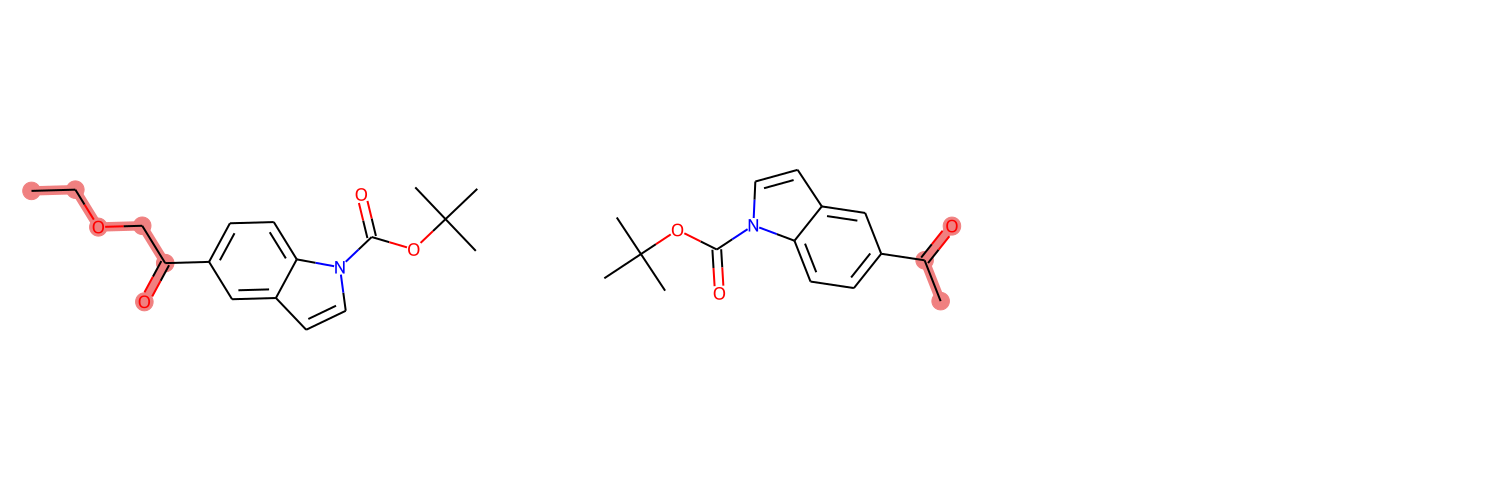

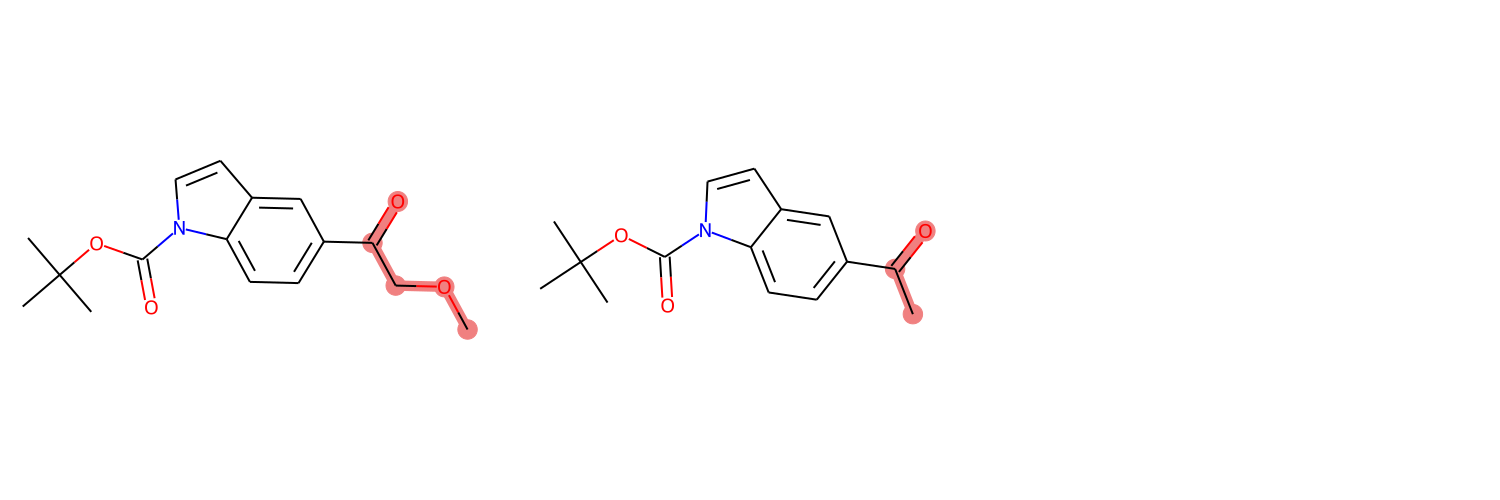

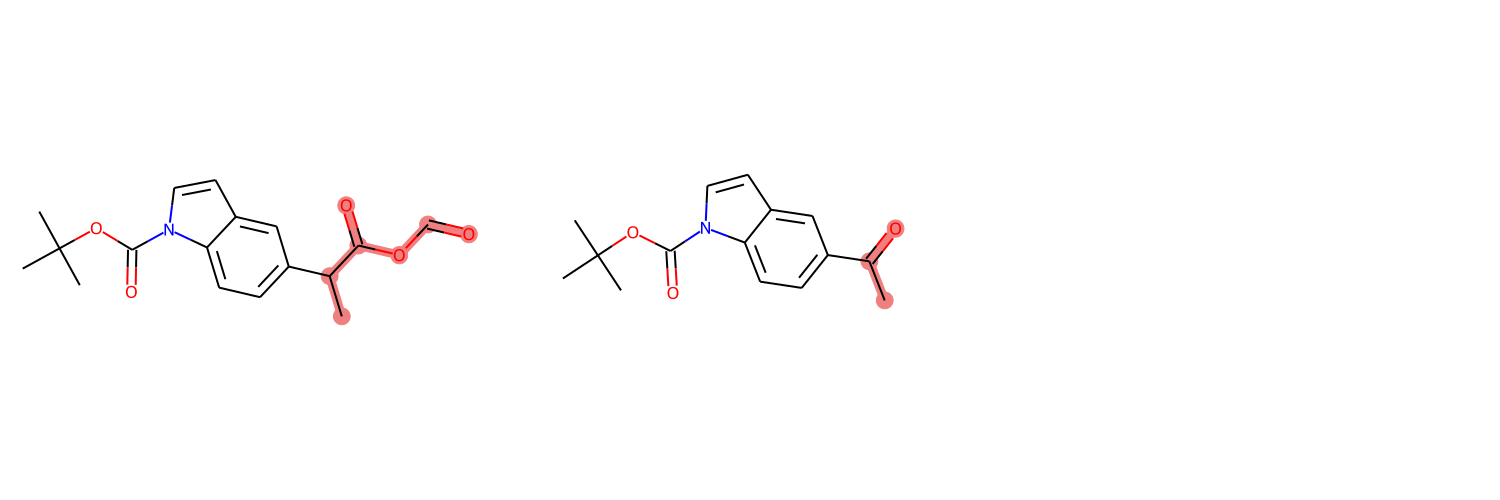

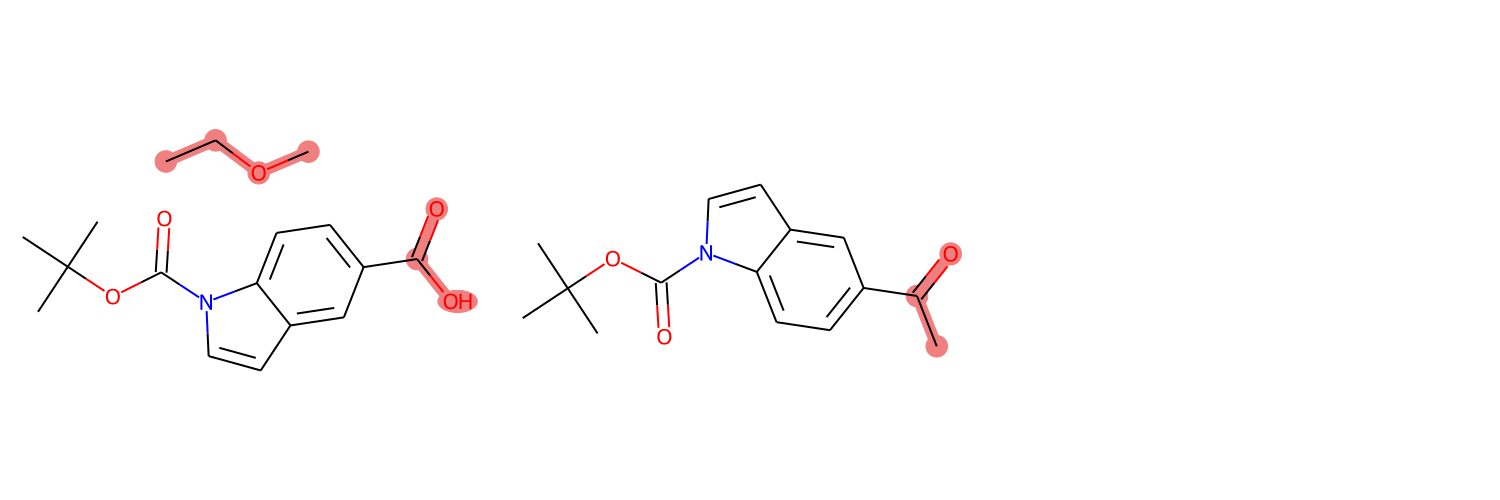

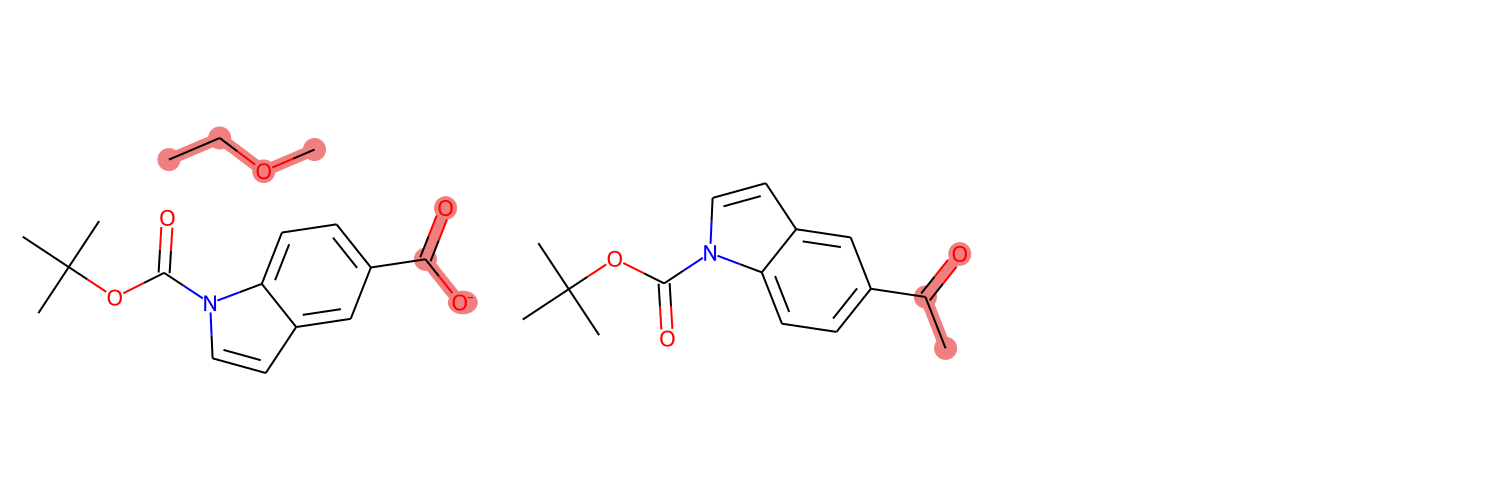

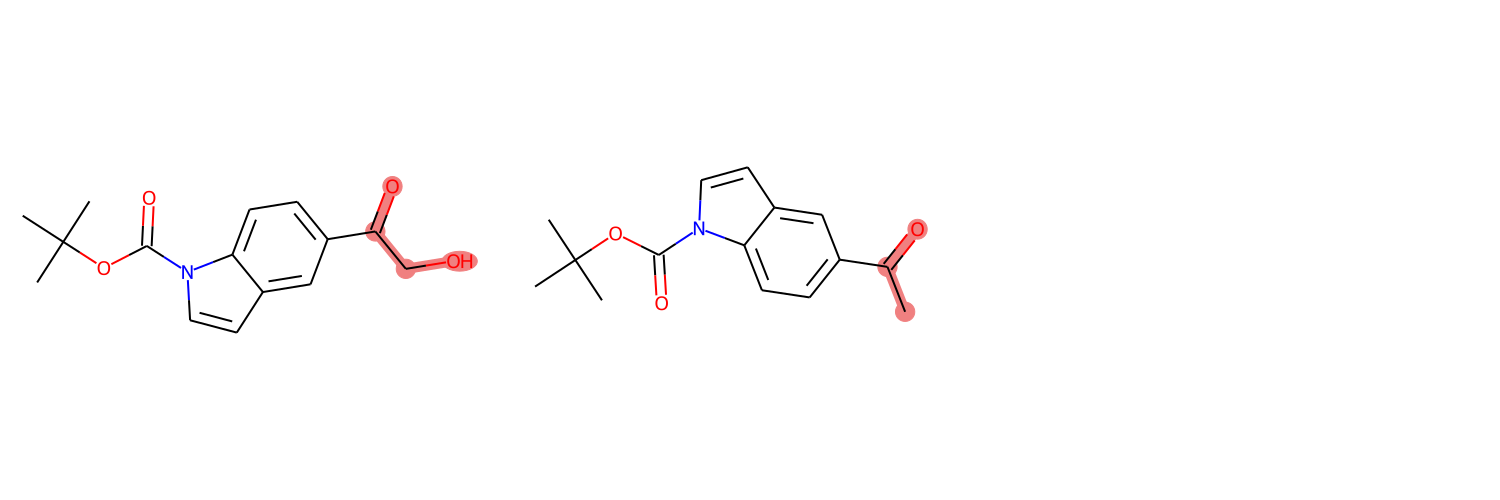

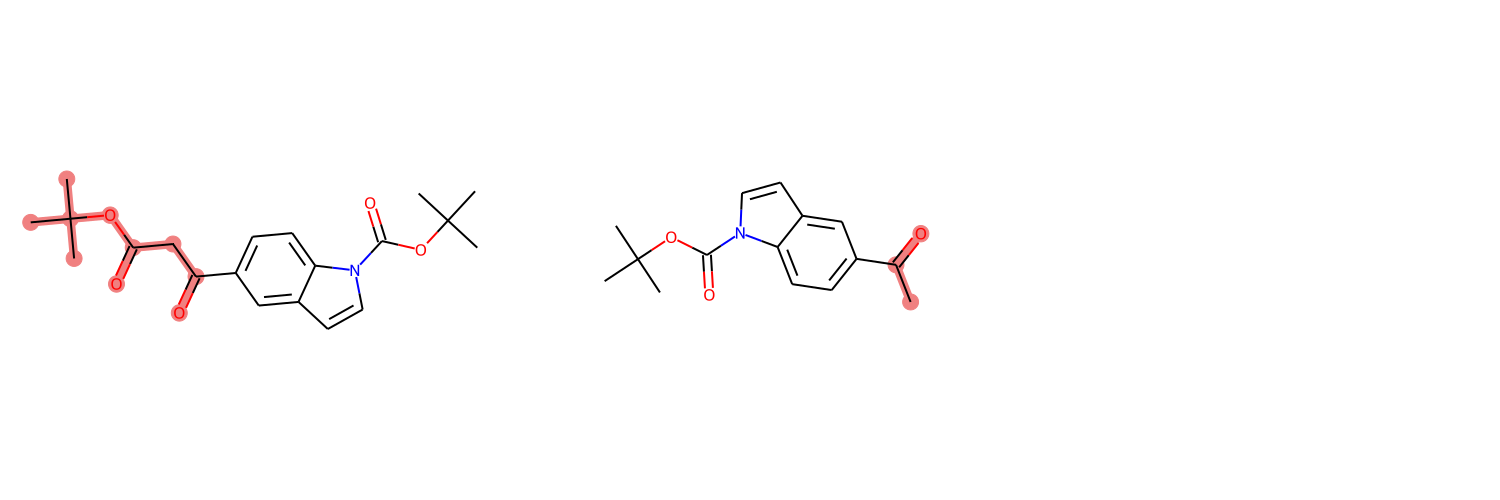

In [11]:
# Plot the result
for mapped_tpl, pred_reacts_smiles in result_list:
    draw_mols([pred_reacts_smiles, prod_smiles], mapped_tpl.split('>>')[::-1])